In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# importing libraries
import keras
from keras.layers import (
    Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape, Lambda)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
Images = np.load('trainImages.npy')
depthImages = np.load('traindepthImages.npy')
testImages = np.load('testImages.npy')

In [ ]:
trainImages = Images[0:8800*4]
valImages = Images[8800*4:] 
traindepthImages = depthImages[0:8800]
valdepthImages = depthImages[8800:]
trainImages = trainImages.reshape(8800, 4, 104, 104).swapaxes(1, 2).swapaxes(2, 3)  #(8800, 104, 104, 4)(#, w, l, #diff aspect)
valImages = valImages.reshape(1000, 4, 104, 104).swapaxes(1, 2).swapaxes(2, 3)  #(1000, 104, 104, 4)(#, w, l, #diff aspect)
traindepthImages = traindepthImages[:, :, :, None]
valdepthImages = valdepthImages[:, :, :, None]
testImages = testImages.reshape(150, 4, 104, 104).swapaxes(1, 2).swapaxes(2, 3)  #(150, 104, 104, 4)(#, w, l, #diff aspect)

(8800, 104, 104, 4)
(1000, 104, 104, 4)
(8800, 104, 104, 1)
(1000, 104, 104, 1)
(150, 104, 104, 4)


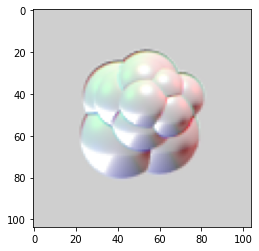

In [ ]:
print(trainImages.shape)
print(valImages.shape)
print(traindepthImages.shape)
print(valdepthImages.shape)
print(testImages.shape)
plt.imshow(trainImages[1])

In [ ]:
#hyperprarameters
img_rows = 104
img_cols = 104
channels = 4
depth_channel = 1
train_img_shape = (img_rows, img_cols, channels)
depth_img_shape = (img_rows, img_cols, depth_channel)

latent_dim = 104
epoch = 1000
batch_size = 10

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# create convolution encoder and decoder
latent_dim = 104

encoder_inputs = keras.Input(shape=train_img_shape)
x = Conv2D(256, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = LeakyReLU(alpha=0.01)(x)
x = Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
x = Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

# convolutional decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256 * 13 * 13, activation="relu")(latent_inputs)
x = Reshape((13, 13, 256))(x)
x = Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
x = Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
x = Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.01)(x)
decoder_outputs = Conv2DTranspose(1, 3, activation='tanh', padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 104, 104, 4) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 52, 52, 256)  9472        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 52, 52, 256)  0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 26, 26, 128)  295040      leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(keras.losses.mean_squared_error(data, reconstruction))
            reconstruction_loss *= 3072
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            beta = 0.1
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(trainImages, traindepthImages, epochs=epoch, batch_size=batch_size)
vae.save_weights("vae_model.h5",save_format='h5')

Epoch 1/1000
880/880 [==============================] - 39s 44ms/step - loss: 79.6752 - reconstruction_loss: 77.9106 - kl_loss: 1.7646
Epoch 2/1000
880/880 [==============================] - 39s 45ms/step - loss: 55.1571 - reconstruction_loss: 53.2862 - kl_loss: 1.8709
Epoch 3/1000
880/880 [==============================] - 39s 45ms/step - loss: 51.6406 - reconstruction_loss: 49.7835 - kl_loss: 1.8571
Epoch 4/1000
880/880 [==============================] - 39s 45ms/step - loss: 50.2004 - reconstruction_loss: 48.3561 - kl_loss: 1.8443
Epoch 5/1000
880/880 [==============================] - 39s 45ms/step - loss: 49.2047 - reconstruction_loss: 47.3794 - kl_loss: 1.8253
Epoch 6/1000
880/880 [==============================] - 39s 45ms/step - loss: 48.2859 - reconstruction_loss: 46.4804 - kl_loss: 1.8055
Epoch 7/1000
880/880 [==============================] - 39s 45ms/step - loss: 47.5806 - reconstruction_loss: 45.7989 - kl_loss: 1.7817
Epoch 8/1000
880/880 [==============================] -

In [ ]:
recon_loss = history.history['reconstruction_loss']
epochs = range(0,epoch)
plt.plot(epochs, recon_loss, 'b', label='Reconstruction loss')
#plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Reconstruct training set
reconstructionImages = []
for image in trainImages[0:100]:
  image = image.reshape(1, 104, 104, 4)
  encoded = encoder.predict(image)
  reconstruction =  decoder.predict(encoded)
  reconstructionImages.append(np.squeeze(reconstruction))
reconstructionImages = np.array(reconstructionImages)
plt.imshow(reconstructionImages[0])

In [ ]:
print(reconstructionImages.shape)
#reconstructionImages = reconstructionImages.swapaxes(2, 3).swapaxes(1, 2).reshape(8800*4, 104, 104)

In [ ]:
traindepthImages = np.squeeze(traindepthImages, axis=(3,))

In [ ]:
print(traindepthImages.shape)

In [ ]:
#Show reconstruct training set
import sklearn.metrics
import math

for i in range(100):
  mse = sklearn.metrics.mean_squared_error(traindepthImages[i], reconstructionImages[i])
  rmse = math.sqrt(mse)
  fig = plt.figure(figsize=(10,10))
  ax1 = fig.add_subplot(221)
  ax1.title.set_text('ground_truth')
  plt.imshow(traindepthImages[i])
  ax2 = fig.add_subplot(222)
  ax2.title.set_text('Reconstruction  RMSE = '+ str(rmse))
  plt.imshow(reconstructionImages[i])
  plt.show()

In [ ]:
#Reconstruct validation set
reconstructionImages_val = []
i = 1
for image in valImages:
  image = image.reshape(1, 104, 104, 4)
  encoded = encoder.predict(image)
  reconstruction =  decoder.predict(encoded)
  reconstruction = np.squeeze(reconstruction)
  rescaled = (255.0 / reconstruction.max() * (reconstruction - reconstruction.min())).astype(np.uint8)
  img = Image.fromarray(rescaled)
  img.save('/content/gdrive/Shared drives/ECE542 Project2/predImages/Pred_val/img_'+str(i)+'.png')
  i += 1
  reconstructionImages_val.append(reconstruction)
reconstructionImages_val = np.array(reconstructionImages_val)
plt.imshow(reconstructionImages_val[0])

In [ ]:
print(img.size)

In [ ]:
#Reconstruct test set
reconstructionImages_test = []
i = 1
for image in testImages:
  image = image.reshape(1, 104, 104, 4)
  encoded = encoder.predict(image)
  reconstruction =  decoder.predict(encoded)
  reconstruction = np.squeeze(reconstruction)
  rescaled = (255.0 / reconstruction.max() * (reconstruction - reconstruction.min())).astype(np.uint8)
  img = Image.fromarray(rescaled)
  img.save('/content/gdrive/Shared drives/ECE542 Project2/predImages/Pred_test/img_'+str(i)+'.png')
  i += 1
  reconstructionImages_test.append(reconstruction)
reconstructionImages_test = np.array(reconstructionImages_test)
plt.imshow(reconstructionImages_test[0])

In [ ]:
#Show reconstruction validation set
valdepthImages = np.squeeze(valdepthImages, axis=(3,))
for i in range(100):
  mse = sklearn.metrics.mean_squared_error(valdepthImages[i], reconstructionImages_val[i])
  rmse = math.sqrt(mse)
  fig = plt.figure(figsize=(10,10))
  ax1 = fig.add_subplot(221)
  ax1.title.set_text('ground_truth')
  plt.imshow(valdepthImages[i])
  ax2 = fig.add_subplot(222)
  ax2.title.set_text('Reconstruction  RMSE = '+ str(rmse))
  plt.imshow(reconstructionImages_val[i])
  plt.show()